# AI-text-detector

In [1]:
from transformers import BertTokenizer, BertForSequenceClassification
import torch
import numpy as np
import seaborn as sns
from torch.utils.data import DataLoader, Dataset

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# optim
import torch.optim as optim

/Users/tonton/anaconda3/envs/t2mENV/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
(3).__add__(4) 
 

7

## Training

In [14]:
# load texts and labels
def text_edit(text):
    # remove first two lines
    text = '\n'.join(text.split('\n')[2:])

    # cut longer than 2000 characters
    text = text[:2000]

    # # remove everything After Kilde:
    # text = text.split('Kilde:')[0]

    # remove empty lines
    # text = '\n'.join([line for line in text.split('\n') if line != ''])

    # remove new lines
    text = ' '.join(text.split('\n'))

    # remove double spaces
    # text = ' '.join(text.split('  '))

    # remove emojis
    # text = text.encode('ascii', 'ignore').decode('ascii')
   

    # Assuming 'text' is defined and contains sentences
    sentences = text.split('.')
    num_sentences = len(sentences)
    if num_sentences > 4:

        # Create an exponential distribution for probabilities
        # The exponential distribution should favor lower indices for rand_low and higher indices for rand_high
        probabilities = np.exp(np.linspace(0, 2, num_sentences-1))
        probabilities /= probabilities.sum()  # Normalize to make it a valid probability distribution

        # Choose rand_low and rand_high using the defined probabilities
        rand_low = np.random.choice(np.arange(num_sentences-1), p=probabilities[::-1])
        rand_high = np.random.choice(np.arange(rand_low+1, num_sentences), 
                        p=probabilities[rand_low:] / probabilities[rand_low:].sum())

        # Join the selected range of sentences
        text = '.'.join(sentences[rand_low:rand_high])

    return text

def load_data():

    import os

    data = {
        'human': [],
        'bot': []
    }

    data_sources = {
        'human' : ['data/heste-nettet-nyheder/'],
        'bot' : ['data/heste-nettet-nyheder-ai/gpt-3.5-turbo/', 'data/heste-nettet-nyheder-ai/gpt-4-0613/']
    }

    for source in data_sources:
        for path in data_sources[source]:
            for filename in os.listdir(path):
                with open(path + filename, 'r', encoding='utf-8') as f:
                    content = f.read()
                    text = text_edit(content)
                    data[source].append(text)

    # cut to same length
    min_len = min(len(data['human']), len(data['bot']))
    data['human'] = data['human'][:min_len]
    data['bot'] = data['bot'][:min_len]
    
    my_texts = np.array(data['human'] + data['bot'])
    my_labels = np.array([0]*len(data['human']) + [1]*len(data['bot'])) 

    return list(my_texts), my_labels

def preprocess(text):
    inputs = tokenizer(text, padding=True, truncation=True, max_length=512, return_tensors="pt")
    return inputs

class TextDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels
        self.inputs = preprocess(texts)

        # dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])
        self.input_ids = self.inputs['input_ids']
        self.attention_mask = self.inputs['attention_mask']

    


    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        input_ids = self.input_ids[idx]
        attention_mask = self.attention_mask[idx]

        return {
            # 'text': text,
            'label': label,
            'input_ids': input_ids,
            'attention_mask': attention_mask
        }


# Assume you're using a GPU for training
device = torch.device("mps" if torch.has_mps else "cpu")
print("Using device:", device)

model_name = "bert-base-multilingual-cased"  # or another model suitable for Danish
local_model = "models/bert_classifier"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(local_model, num_labels=2)

texts, labels = load_data()
texts_train, texts_test, labels_train, labels_test = train_test_split(texts, labels, test_size=0.2)

dataset_train = TextDataset(texts_train, labels_train)
dataloader_train = DataLoader(dataset_train, batch_size=8, shuffle=True)

dataset_test = TextDataset(texts_test, labels_test)
dataloader_test = DataLoader(dataset_test, batch_size=8, shuffle=True)


# print table summary with total samples in each dataset, positive samples, and negative samples
def pretty_print_info_table(labels_train, labels_test):
    data_for_table = {
        'train': {
            'total': len(labels_train),
            'pos': np.sum(labels_train),
            'neg': len(labels_train) - np.sum(labels_train)
        },
        'test': {
            'total': len(labels_test),
            'pos': np.sum(labels_test),
            'neg': len(labels_test) - np.sum(labels_test)
        }
    }
    data_for_table['total'] = {
        'total': data_for_table['train']['total'] + data_for_table['test']['total'],
        'pos': data_for_table['train']['pos'] + data_for_table['test']['pos'],
        'neg': data_for_table['train']['neg'] + data_for_table['test']['neg']
    }

    print("""
    Info table:
    +----------------+---------+---------+-------+
    |                | Training| Testing | Total
    +----------------+---------+---------+-------+
    | Total samples  | {:7d} | {:7d} | {:7d} |
    | Pos. samples   | {:7d} | {:7d} | {:7d} |  (AI generated)
    | Neg. samples   | {:7d} | {:7d} | {:7d} |  (Human written)
    """.format(
        data_for_table['train']['total'],
        data_for_table['test']['total'],
        data_for_table['total']['total'],
        data_for_table['train']['pos'],
        data_for_table['test']['pos'],
        data_for_table['total']['pos'],
        data_for_table['train']['neg'],
        data_for_table['test']['neg'],
        data_for_table['total']['neg'],
        
        ))

pretty_print_info_table(labels_train, labels_test)

# weight for positive class
weight_pos = len(texts_train) / (2 * np.sum(labels_train))
# weight for negative class
weight_neg = len(texts_train) / (2 * (len(texts_train) - np.sum(labels_train)))
# class weights
class_weights = torch.tensor([weight_neg, weight_pos])

# the class weights are defined, but im unsure how to apply them as the loss function is incooperated in the forward pass of the model, so i will just balance the dataset instead.


Using device: mps


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



    Info table:
    +----------------+---------+---------+-------+
    |                | Training| Testing | Total
    +----------------+---------+---------+-------+
    | Total samples  |     982 |     246 |    1228 |
    | Pos. samples   |     488 |     126 |     614 |  (AI generated)
    | Neg. samples   |     494 |     120 |     614 |  (Human written)
    


In [15]:

model.to(device)

# freeze all layers except the last one
for param in model.parameters():
    param.requires_grad = False

for param in model.classifier.parameters():
    param.requires_grad = True


# Training loop
from transformers import AdamW
lr = 1e-4
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=lr/100)

# early stopping
def early_stopping(losses, patience=10):
    if len(losses) < patience:
        return False
    return losses[-1] > max(losses[-patience:-1])

losses = {'train': [], 'test': []}
num_epochs = 40
for epoch in range(num_epochs):
    model.train()
    # Train
    loss_total_train = 0
    for i, batch in enumerate(dataloader_train):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)


        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        #rint(outputs)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        loss_total_train += loss.item()

    print(f"Epoch {epoch} loss: {loss_total_train / len(dataset_train)}")
    losses['train'].append(loss_total_train / len(dataset_train))

    # Test
    model.eval()
    loss_total_test = 0
    with torch.no_grad():
        for i, batch in enumerate(dataloader_test):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            loss_total_test += loss.item()

    print(f"Epoch {epoch} test loss: {loss_total_test / len(dataset_test)}")
    losses['test'].append(loss_total_test / len(dataset_test))

    # if validation loss is lowest, save model
    if min(losses['test']) == losses['test'][-1]:
        model.save_pretrained("models/bert_classifier", save_function=torch.save)
        print("Model saved")

    if early_stopping(losses['test']):
        print("Early stopping")
        break

    




Epoch 0 loss: 0.08514317329935046
Epoch 0 test loss: 0.08414930250586533
Model saved
Epoch 1 loss: 0.0831009092496029
Epoch 1 test loss: 0.08254753864877593
Model saved
Epoch 2 loss: 0.08281250246430609
Epoch 2 test loss: 0.08069110958556819
Model saved
Epoch 3 loss: 0.08032631783038681
Epoch 3 test loss: 0.0795061221209968
Model saved
Epoch 4 loss: 0.07906747216362574
Epoch 4 test loss: 0.07811600260618257
Model saved
Epoch 5 loss: 0.07812073341212301
Epoch 5 test loss: 0.07686132907382841
Model saved
Epoch 6 loss: 0.07695296977299537
Epoch 6 test loss: 0.07580558022832483
Model saved
Epoch 7 loss: 0.07659121279561107
Epoch 7 test loss: 0.07456947148330813
Model saved
Epoch 8 loss: 0.0746658636814708
Epoch 8 test loss: 0.07310762952982895
Model saved
Epoch 9 loss: 0.07531950818545464
Epoch 9 test loss: 0.07241171513631092
Model saved
Epoch 10 loss: 0.07308751739212549
Epoch 10 test loss: 0.0709216440838527
Model saved
Epoch 11 loss: 0.07323848208803266
Epoch 11 test loss: 0.0700890160

Text(0, 0.5, 'Loss')

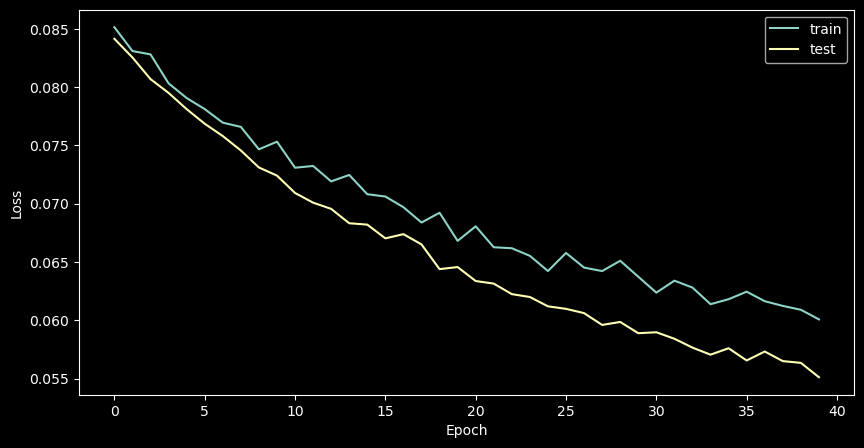

In [16]:
# load model
model = BertForSequenceClassification.from_pretrained("models/bert_classifier")
plt.style.use('dark_background')

# Plot the losses
plt.figure(figsize=(10, 5))
plt.plot(losses['train'], label='train')
plt.plot(losses['test'], label='test')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
# set background to black



## Model Validation

              precision    recall  f1-score   support

           0       0.84      0.79      0.82       120
           1       0.81      0.86      0.83       126

    accuracy                           0.83       246
   macro avg       0.83      0.82      0.82       246
weighted avg       0.83      0.83      0.82       246



Text(0.5, 1.0, 'Confusion matrix for BERT detector, for detecting AI generated texts')

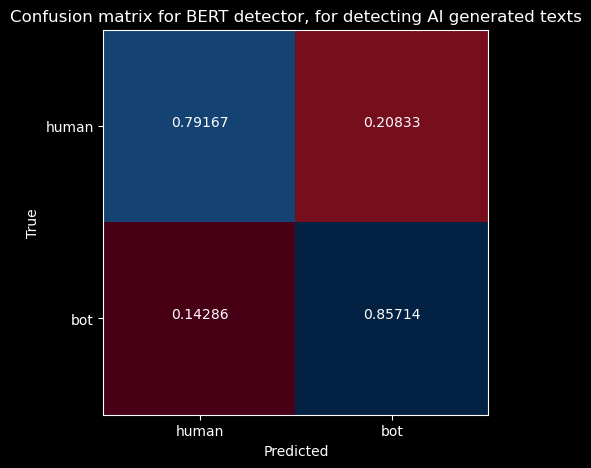

In [17]:
# Evaluate the model
from sklearn.metrics import classification_report, confusion_matrix

model.to(device)

model.eval()
predictions = []
true_labels = []
with torch.no_grad():
    for i, batch in enumerate(dataloader_test):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predictions.extend(logits.argmax(dim=1).cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

print(classification_report(true_labels, predictions))

# Confusion matrix
cm = confusion_matrix(true_labels, predictions)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(5, 5))
plt.imshow(cm, cmap=plt.cm.RdBu, alpha=.7 )

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, "{:.5f}".format(cm[i, j]), horizontalalignment="center")

plt.xticks([0, 1], ['human', 'bot'])
plt.yticks([0, 1], ['human', 'bot'])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion matrix for BERT detector, for detecting AI generated texts")

## Model Application

In [18]:
# load my model
from transformers import BertForSequenceClassification
model = BertForSequenceClassification.from_pretrained("models/bert_classifier")
model.to(device);

In [19]:
# test
test_string = "This is a test"

model.eval()    
with torch.no_grad():
    inputs = preprocess(test_string)
    input_ids = inputs['input_ids'].squeeze(1).to(device)
    attention_mask = inputs['attention_mask'].squeeze(1).to(device)
    outputs = model(input_ids, attention_mask=attention_mask)
    logits = outputs.logits
    print(logits)
    print(torch.argmax(logits).item())

tensor([[ 0.5200, -0.1810]], device='mps:0')
0


## Ftitting it into router format

In [20]:
# to fit into the pipeline i need to make a predict function

def predict(text):
    model.eval()    
    with torch.no_grad():
        inputs = preprocess(text)
        input_ids = inputs['input_ids'].squeeze(1).to(device)
        attention_mask = inputs['attention_mask'].squeeze(1).to(device)
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        return torch.argmax(logits).item()

def predict_batches(texts, batch_size=256, device='cpu'):
    dataset = TextDataset(texts, [0]*len(texts))
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    model.to(device)
    model.eval()  
    predictions = []  
    with torch.no_grad():
        for i, batch in enumerate(dataloader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            predictions.extend(logits.argmax(dim=1).cpu().numpy())

    return predictions

# test
test_string = "This is a test"
print(predict(test_string))

0


## Test on data.csv

In [21]:
df = pd.read_csv('data.csv')
df

df['bert_prediction'] = df['text'].apply(predict)

df

,text,is_generated,bert_prediction
0,"Det gør firmaerne, der står bag AI'en - eksemp...",0,1
1,"Tror det bliver for kedeligt, hvis vi bare læs...",0,0
2,"Godt spørgsmål! Det er nemlig meget, meget svæ...",0,0
3,"Ja, det er begyndt at ske. Det er dog ikke så ...",1,1
4,Det vil jeg tro - uden at vide det helt præcis...,0,1
5,"Selvom det er svært at forudsige, hvornår AI v...",1,1
6,"Det afhænger nok meget af, hvor fremme i skoen...",0,1
7,"En tech-korrespondent er en journalist, der dæ...",1,1
8,"ChatGPT er en generativ AI-model, der lærer at...",1,1
9,"Hej, den har læst en masse tekst og så regner ...",0,1


## Test on val.csv

In [22]:
import pandas as pd
df = pd.read_csv('data/val.csv')
import time
#df['bert_prediction'] = df['text'].apply(predict)
run_times = {}
for bs in np.linspace(30, 120, 4):
    bs = int(bs)
    start = time.time()
    df['pred'] = predict_batches(df['text'].tolist(), batch_size=bs , device='mps')
    end = time.time()
    run_times[bs] = end - start
    print(f"Batch size: {bs}, time: {end - start}")
    break

plt.figure(figsize=(10, 5))

plt.plot(list(run_times.keys()), list(run_times.values()))
plt.xlabel('Batch size')
plt.ylabel('Time (s)')
plt.title('Time to predict with BERT, depending on batch size')
plt.close()


Batch size: 30, time: 17.27810788154602


In [23]:
# save df['pred']
np.savez('bert_predictions.npz', pred=df['pred'].to_numpy())
# load df['pred']
labels = np.load('bert_predictions.npz')
labels['pred'].tolist()

[1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,


In [166]:
df2 = pd.read_csv('data/val.csv')

In [169]:
df2.values

array([['I min optik er god forskning det samme som ""struktureret kreativitet"". Så intuition er bestemt en god ting at have med sig - udover at man selvfølgelig skal kunne nogle forskningsteknikker. Men forskningsteknikkerne kan man lære, det er tilgengæld ikke som nemt at lære intuition. Så hvis du er en person, der er god til intuition, så er du allerede godt på vej til at blive ""god"".'],
       ['Jeg synes, der er rigtig gode erstatninger på alle pladser. Mathias Gidsel må meget gerne holde sig skadesfri gennem hele VM, men Mads Hoxer har bevist i Aalborg, at han allerede er på et meget højt niveau, selvom han står i Malmø som slutrundedebutant.'],
       ['Selvom der er tale om en sag, der har været i retssystemet i flere år, og som har haft en lang og omfattende behandling, så er dommen ikke blevet ud til læsning for almindeligt dødelige.\n\nRetten har ikke truffet denne dom endnu, og det er ikke almindeligt, at domme bliver ud til læsning før de er truffet. Det er normalt, at

In [200]:
list(np.random.randint(0, 1, 4))

[0, 0, 0, 0]